# Imports

In [1]:

import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import bambi as bmb
import xarray as xr

from ipywidgets import interact
import ipywidgets as ipyw

# Penguins

## Load and plot data

In [2]:
penguins = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data/penguins.csv").dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


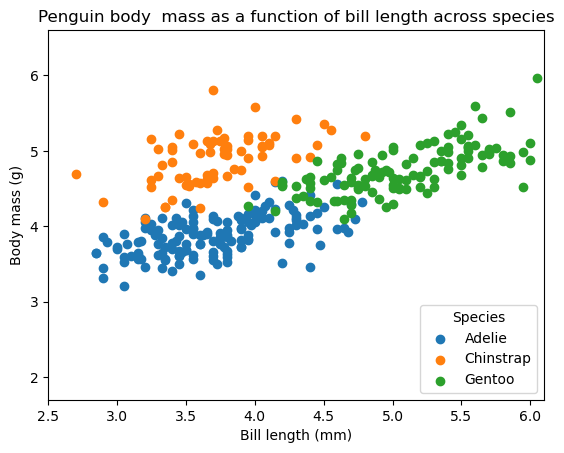

In [3]:
%matplotlib inline
# Get unique categories
unique_categories = np.unique(penguins.species)

# Create color map for categories
category_color_map = {cat: f"C{i}" for i, cat in enumerate(unique_categories)}

# Generate colors for each category
colors = [category_color_map[cat] for cat in penguins.species]

# Create scatter plot for each category
for cat in unique_categories:
    category_data = penguins[penguins.species == cat]
    plt.scatter(category_data.body_mass, category_data.bill_length, c=category_color_map[cat], label=cat)

# Add labels and legend
plt.ylim([1.7, 6.6])
plt.xlim([2.5, 6.1])
plt.ylabel("Body mass (g)")
plt.xlabel("Bill length (mm)")
plt.legend(labels=unique_categories, loc="lower right", title="Species")
plt.title("Penguin body  mass as a function of bill length across species")
plt.show()

## Pooled models

### Pooled PyMC model

In [4]:
coords = {"data": np.arange(len(penguins))}

with pm.Model(coords=coords) as model_pooled_pm:
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", sigma=1)

    μ = pm.Deterministic("μ", β0 + β1 * penguins.bill_length, dims="data")
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=penguins.body_mass, dims="data")

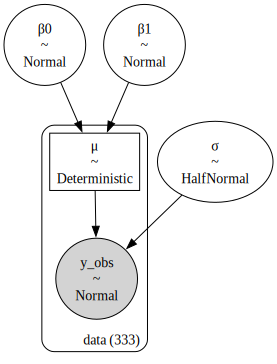

In [5]:
pm.model_to_graphviz(model_pooled_pm)

In [6]:
idata_pooled_pm = pm.sample(model=model_pooled_pm, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


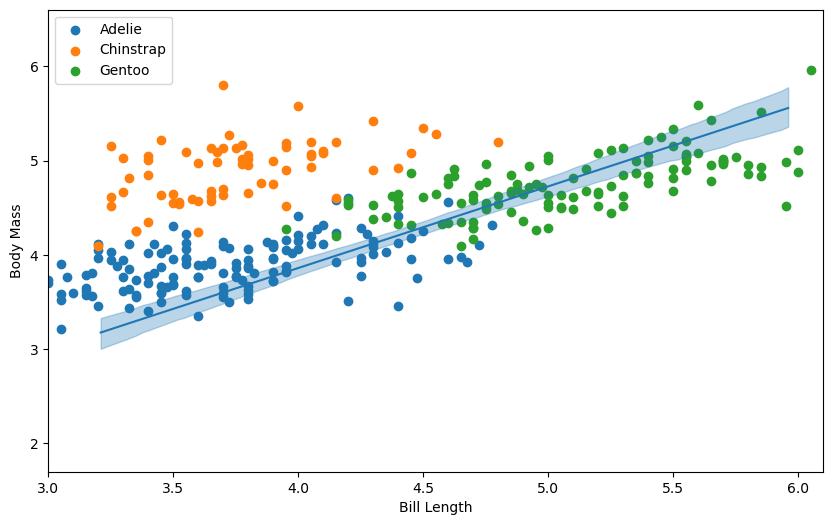

In [7]:
x_grid = xr.DataArray(
    np.linspace(penguins.bill_length.min(), penguins.bill_length.max(), 100),
    dims="plot_x"
)
posterior = idata_pooled_pm.posterior
μ_samples = (
    posterior["β0"] + posterior["β1"] * x_grid
)
fig, ax = plt.subplots(figsize=(10, 6))

for cat in unique_categories:
    category_data = penguins[penguins.species == cat]
    plt.scatter(category_data.body_mass, category_data.bill_length, c=category_color_map[cat], label=cat)

mean_μ = μ_samples.mean(dim=("chain", "draw"))
ax.plot(x_grid, mean_μ, color="C0")

# Plot the HDI band
az.plot_hdi(x_grid, μ_samples, hdi_prob=0.94, color="C0", smooth=False, fill_kwargs={"alpha":0.3}, ax=ax)

ax.set_ylim([1.7, 6.6])
ax.set_xlim([3.0, 6.1])
ax.set_xlabel("Bill Length")
ax.set_ylabel("Body Mass")
ax.legend()
plt.show()


### Pooled Bambi Model

In [8]:
model_pooled_bmb = bmb.Model("body_mass ~ bill_length", data=penguins)
idata_pooled_bmb = model_pooled_bmb.fit(random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, bill_length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


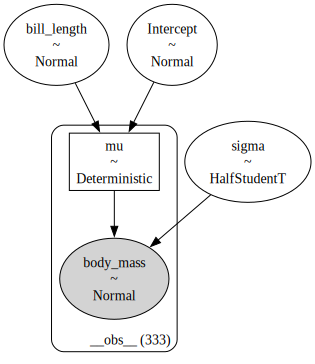

In [9]:
model_pooled_bmb.graph()

In [10]:
idata_pooled_bmb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length


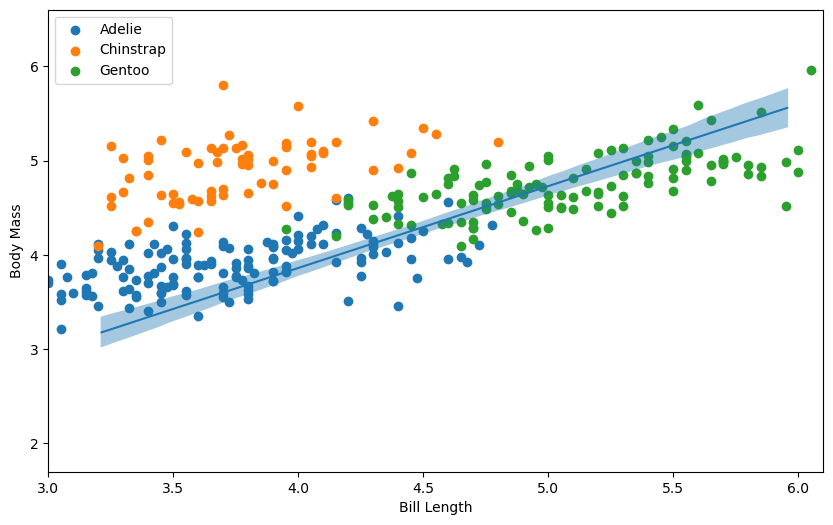

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

for cat in unique_categories:
    category_data = penguins[penguins.species == cat]
    plt.scatter(category_data.body_mass, category_data.bill_length, c=category_color_map[cat], label=cat)

bmb.interpret.plot_predictions(model_pooled_bmb, idata_pooled_bmb, ["bill_length"], ax=ax)


ax.set_ylim([1.7, 6.6])
ax.set_xlim([3.0, 6.1])
ax.set_xlabel("Bill Length")
ax.set_ylabel("Body Mass")
ax.legend()
plt.show()


## Unpooled models

### Unpooled PyMC model

In [12]:
species_codes, species_categories = pd.factorize(penguins['species'])
penguins['species_code'] = species_codes

coords = {"data": np.arange(len(penguins)), "species": species_categories}

with pm.Model(coords=coords) as model_unpooled_pm:
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    β_species = pm.Normal("β_species", mu=0, sigma=10, dims="species")
    σ = pm.HalfNormal("σ", sigma=1)

    μ = pm.Deterministic(
        "μ", 
        β0 + β1 * penguins.bill_length.values + β_species[species_codes], 
        dims="data"
    )
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=penguins.body_mass, dims="data")

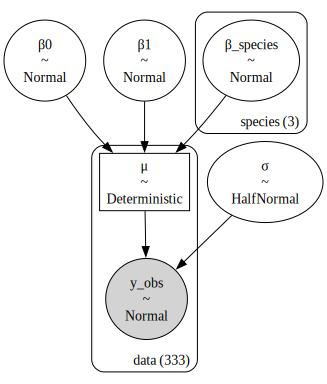

In [13]:
pm.model_to_graphviz(model_unpooled_pm)

In [14]:
idata_unpooled_pm = pm.sample(model=model_unpooled_pm, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, β_species, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [15]:
idata_unpooled_pm

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

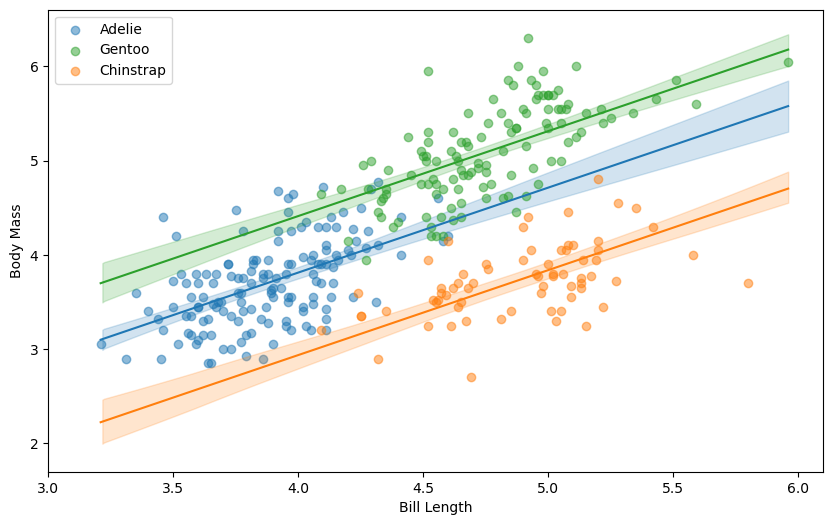

In [16]:
# Define x-grid
x_grid = xr.DataArray(
    np.linspace(penguins.bill_length.min(), penguins.bill_length.max(), 100),
    dims="plot_x"
)

posterior = idata_unpooled_pm.posterior  # Make sure this points to the correct InferenceData object

fig, ax = plt.subplots(figsize=(10, 6))

# Loop over species
for cat in species_categories:
    # Scatter data points for the species
    category_data = penguins[penguins.species == cat]
    ax.scatter(
        category_data.bill_length, 
        category_data.body_mass, 
        color=category_color_map[cat], 
        alpha=0.5, 
        label=cat
    )

    # Get the species index
    cat_index = np.where(species_categories == cat)[0][0]
    
    # Calculate μ_samples per species
    μ_samples = (
        posterior["β0"] +
        posterior["β1"] * x_grid +
        posterior["β_species"][:, :, cat_index]
    )
    
    # Mean line
    mean_μ = μ_samples.mean(dim=("chain", "draw"))
    ax.plot(x_grid, mean_μ, color=category_color_map[cat])
    
    # HDI band
    az.plot_hdi(
        x_grid, μ_samples, hdi_prob=0.94, 
        color=category_color_map[cat], 
        fill_kwargs={"alpha":0.2}, 
        ax=ax
    )

ax.set_ylim([1.7, 6.6])
ax.set_xlim([3.0, 6.1])
ax.set_xlabel("Bill Length")
ax.set_ylabel("Body Mass")
ax.legend()
plt.show()

#### Pair plot for unpooled PyMC model

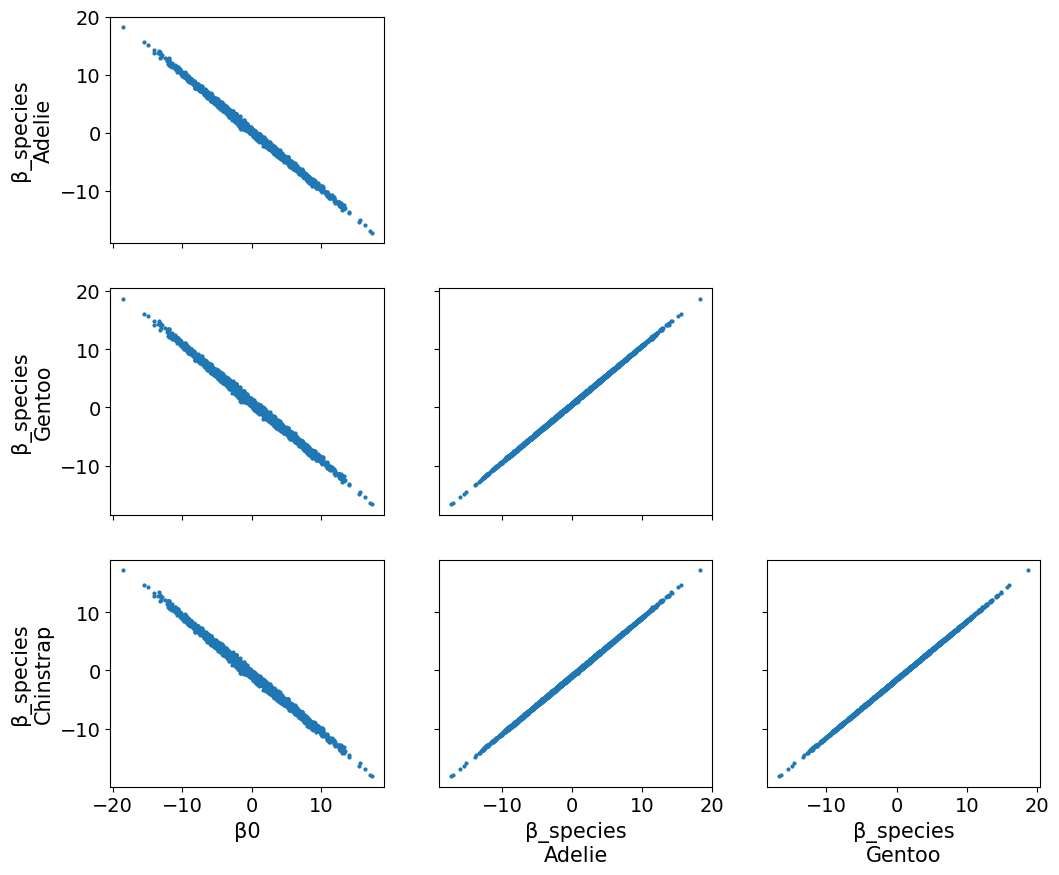

In [17]:
plt.rcParams.update({'font.size': 14})  # Set base font size
az.plot_pair(
    idata_unpooled_pm, 
    var_names=['β0', 'β_species'],
    textsize=14,          # Control text size in the plot
    figsize=(12, 10)      # Make the figure larger
);

### Unpooled Bambi model

In [47]:
model_unpooled_bmb = bmb.Model("body_mass ~ bill_length + species", data=penguins)
idata_unpooled_bmb = model_unpooled_bmb.fit(random_seed=123, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, bill_length, species]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


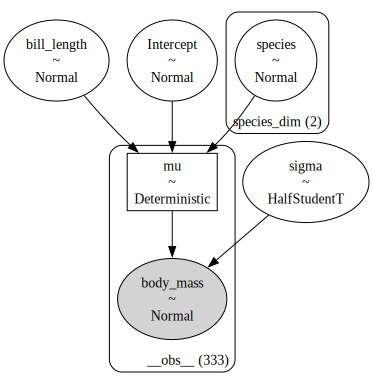

In [19]:
model_unpooled_bmb.graph()

In [20]:
idata_unpooled_bmb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

#### Joint plot for unpooled Bambi model

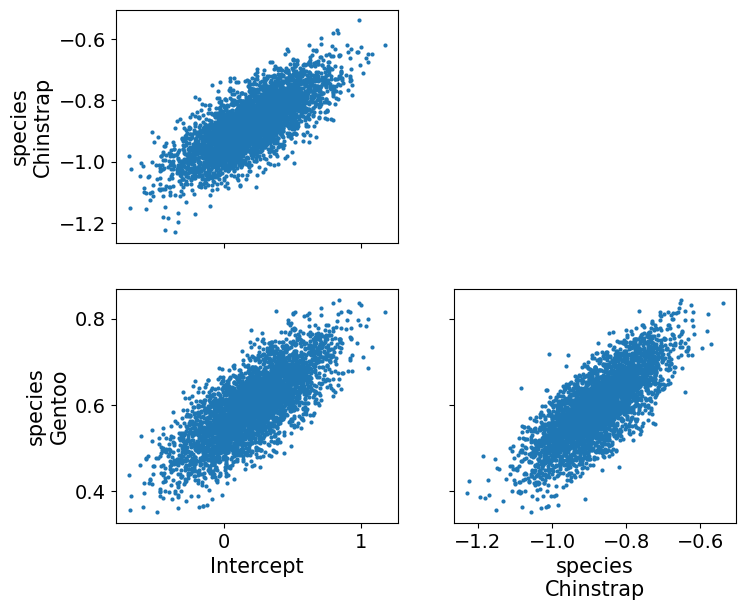

In [21]:
plt.rcParams.update({'font.size': 14})  # Set base font size
az.plot_pair(
    idata_unpooled_bmb, 
    var_names=['Intercept', 'species'],
    textsize=14,          # Control text size in the plot
    figsize=(8, 6.66)      # Make the figure larger
);

Text(<xarray.DataArray 'species' ()> Size: 8B
array(0.5961184)
Coordinates:
    species_dim  <U9 36B 'Gentoo', 0.4, '0.60')

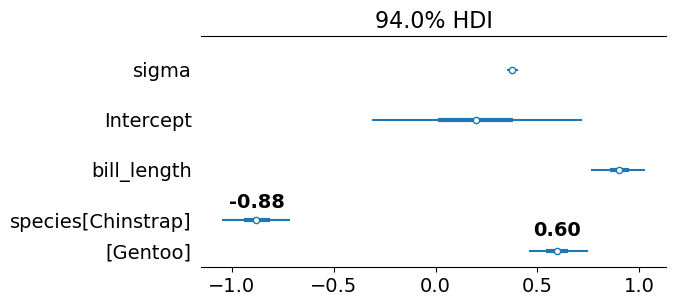

In [22]:
ax = az.plot_forest(idata_unpooled_bmb, combined=True, figsize=(6, 3));
mean_chinstrap = idata_unpooled_bmb.posterior["species"].sel(species_dim="Chinstrap").mean()
mean_gentoo = idata_unpooled_bmb.posterior["species"].sel(species_dim="Gentoo").mean()
ax[0].annotate(f"{mean_chinstrap.item():.2f}", (mean_chinstrap , 1.15), weight='bold', horizontalalignment='center')
ax[0].annotate(f"{mean_gentoo.item():.2f}", (mean_gentoo , 0.4), weight='bold', horizontalalignment='center')

c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length, species


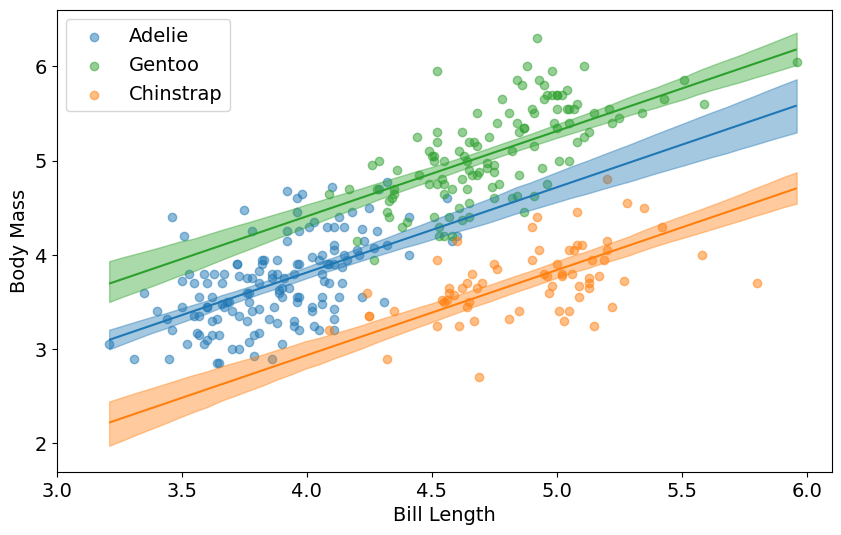

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

for cat in species_categories:
    # Scatter data points for the species
    category_data = penguins[penguins.species == cat]
    ax.scatter(
        category_data.bill_length, 
        category_data.body_mass, 
        color=category_color_map[cat], 
        alpha=0.5, 
        label=cat
    )

bmb.interpret.plot_predictions(model_unpooled_bmb, idata_unpooled_bmb, ["bill_length",  "species"], ax=ax)

ax.set_ylim([1.7, 6.6])
ax.set_xlim([3.0, 6.1])
ax.set_xlabel("Bill Length")
ax.set_ylabel("Body Mass")
ax.legend()
plt.show()

### Fixed PyMC  unpooled model

In [24]:
species_codes, species_categories = pd.factorize(penguins['species'])

# Create dummy variables for non-reference species
n_species = len(species_categories)
dummy_matrix = np.zeros((len(penguins), n_species - 1))
for i in range(1, n_species):
    dummy_matrix[:, i-1] = (species_codes == i)

coords = {
    "data": np.arange(len(penguins)), 
    "non_ref_species": species_categories[1:]  # All but reference species
}

with pm.Model(coords=coords) as model_unpooled_pm_fixed:
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    β_species = pm.Normal("β_species", mu=0, sigma=10, dims="non_ref_species")
    σ = pm.HalfNormal("σ", sigma=1)
    
    # Reference species (Adelie) is captured by β0
    # Other species get their own coefficient
    μ = pm.Deterministic(
        "μ", 
        β0 + β1 * penguins.bill_length.values + pm.math.dot(dummy_matrix, β_species),
        dims="data"
    )
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=penguins.body_mass, dims="data")


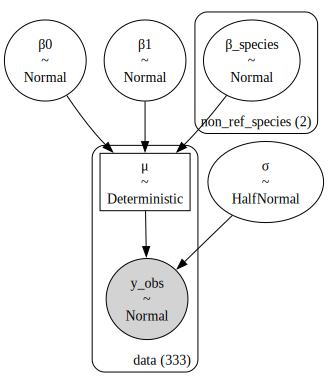

In [25]:
pm.model_to_graphviz(model_unpooled_pm_fixed)

In [26]:
idata_unpooled_pm_fixed = pm.sample(model=model_unpooled_pm_fixed, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, β_species, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


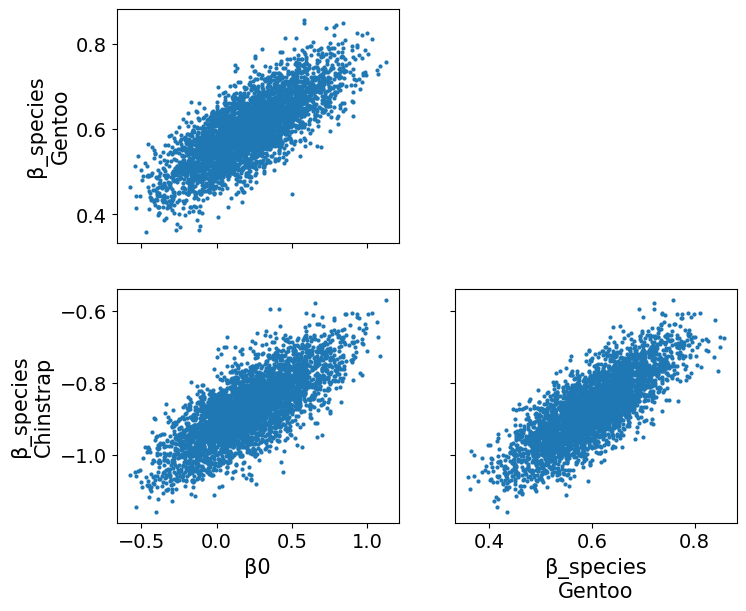

In [27]:
plt.rcParams.update({'font.size': 14})  # Set base font size
az.plot_pair(
    idata_unpooled_pm_fixed, 
    var_names=['β0', 'β_species'],
    textsize=14,          # Control text size in the plot
    figsize=(8, 6.666)      # Make the figure larger
);

## Hierarchical models

### Hierarchy in the intercept

#### PyMC model hierarchical in the intercept

In [28]:
species_codes, species_categories = pd.factorize(penguins['species'])
penguins['species_code'] = species_codes

coords = {"data": np.arange(len(penguins)), "species": species_categories}

with pm.Model(coords=coords) as model_hierarchical_pm:
    μ_β_species = pm.Normal('μ_β_species', mu=0, sigma=10)
    σ_β_species = pm.HalfNormal('σ_β_species', sigma=5)

    β1 = pm.Normal("β1", mu=0, sigma=10)
    β_species = pm.Normal("β_species", mu=μ_β_species, sigma=σ_β_species, dims="species")
    σ = pm.HalfNormal("σ", sigma=1)

    μ = pm.Deterministic(
        "μ", 
        β1 * penguins.bill_length.values + β_species[species_codes], 
        dims="data"
    )
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=penguins.body_mass, dims="data")

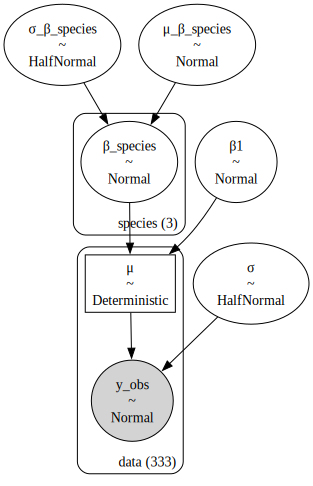

In [29]:
pm.model_to_graphviz(model_hierarchical_pm)

In [30]:
idata_hiearchical_pm = pm.sample(model=model_hierarchical_pm)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_β_species, σ_β_species, β1, β_species, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


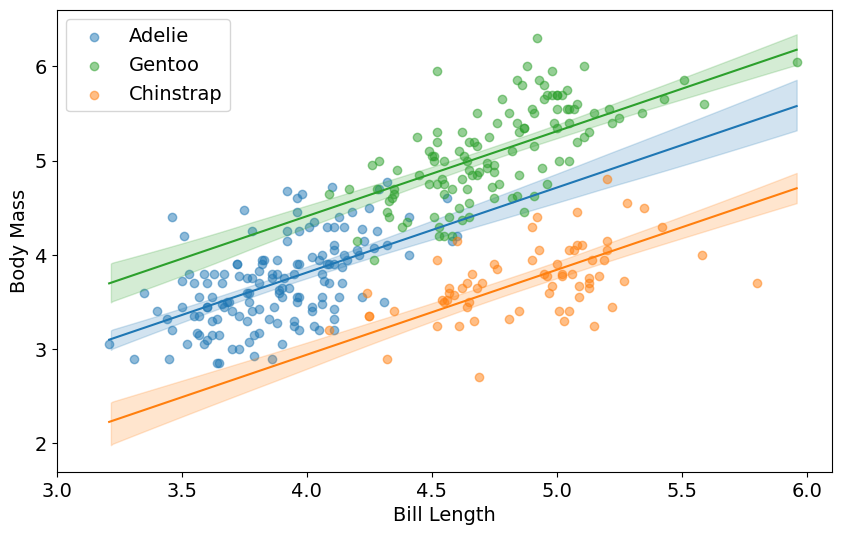

In [31]:
x_grid = xr.DataArray(
    np.linspace(penguins.bill_length.min(), penguins.bill_length.max(), 100),
    dims="plot_x"
)

posterior = idata_hiearchical_pm.posterior  # Make sure this points to the correct InferenceData object

fig, ax = plt.subplots(figsize=(10, 6))

# Loop over species
for cat in species_categories:
    # Scatter data points for the species
    category_data = penguins[penguins.species == cat]
    ax.scatter(
        category_data.bill_length, 
        category_data.body_mass, 
        color=category_color_map[cat], 
        alpha=0.5, 
        label=cat
    )

    # Get the species index
    cat_index = np.where(species_categories == cat)[0][0]
    
    # Calculate μ_samples per species
    μ_samples = (
        posterior["β1"] * x_grid +
        posterior["β_species"][:, :, cat_index]
    )
    
    # Mean line
    mean_μ = μ_samples.mean(dim=("chain", "draw"))
    ax.plot(x_grid, mean_μ, color=category_color_map[cat])
    
    # HDI band
    az.plot_hdi(
        x_grid, μ_samples, hdi_prob=0.94, 
        color=category_color_map[cat], 
        fill_kwargs={"alpha":0.2}, 
        ax=ax
    )


ax.set_ylim([1.7, 6.6])
ax.set_xlim([3.0, 6.1])
ax.set_xlabel("Bill Length")
ax.set_ylabel("Body Mass")
ax.legend()
plt.show()


#### Bambi model hierarchical in the intercept

In [ ]:
model_hierarchy_bmb = bmb.Model("body_mass ~ 0 + bill_length + (1|species)", data=penguins)
idata_hierarchy_bmb = model_hierarchy_bmb.fit(random_seed=123, target_accept=0.999, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bill_length, 1|species_sigma, 1|species_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [44]:
model_hierarchy_bmb

       Formula: body_mass ~ 0 + bill_length + (1|species)
        Family: gaussian
          Link: mu = identity
  Observations: 333
        Priors: 
    target = mu
        Common-level effects
            bill_length ~ Normal(mu: 0.0, sigma: 3.681)
        
        Group-level effects
            1|species ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 16.3182))
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 5.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [43]:
az.summary(idata_hierarchy_bmb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.376,0.015,0.350,0.404,0.000,0.000,1841.0,1709.0,1.00
bill_length,0.909,0.058,0.803,1.019,0.002,0.001,1047.0,1565.0,1.00
1|species_sigma,1.301,1.213,0.302,2.982,0.044,0.101,597.0,1068.0,1.01
1|species[Adelie],0.177,0.226,-0.246,0.591,0.007,0.005,1026.0,1618.0,1.00
1|species[Chinstrap],-0.703,0.286,-1.236,-0.168,0.009,0.006,1067.0,1675.0,1.00
1|species[Gentoo],0.766,0.277,0.248,1.283,0.008,0.006,1053.0,1641.0,1.00


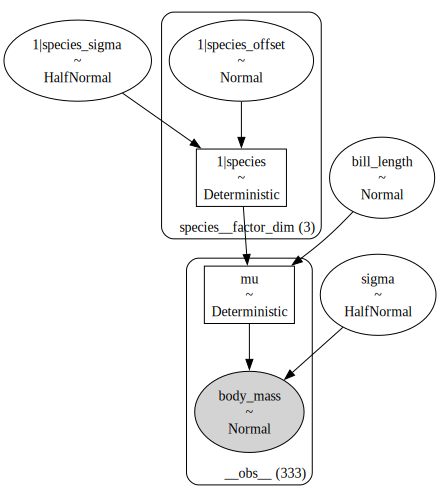

In [34]:
model_hierarchy_bmb.graph()

In [35]:
idata_hierarchy_bmb

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length, species


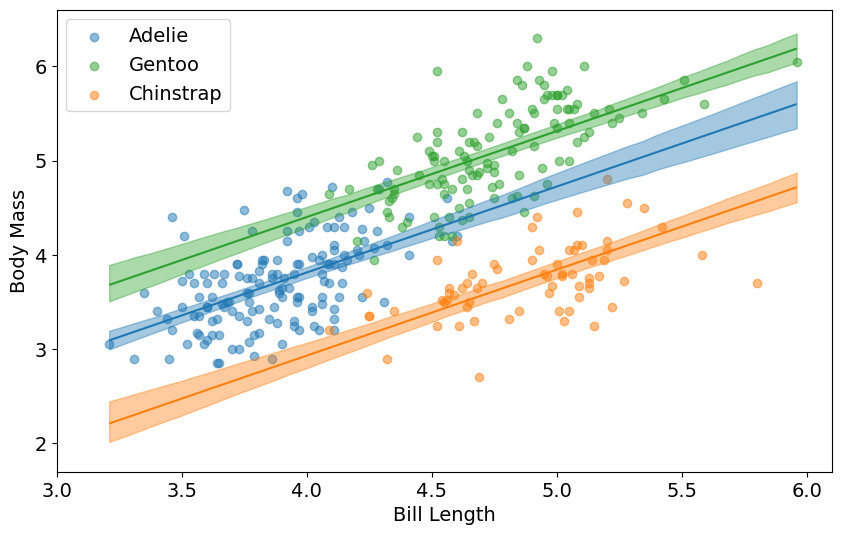

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

for cat in species_categories:
    # Scatter data points for the species
    category_data = penguins[penguins.species == cat]
    ax.scatter(
        category_data.bill_length, 
        category_data.body_mass, 
        color=category_color_map[cat], 
        alpha=0.5, 
        label=cat
    )

bmb.interpret.plot_predictions(model_hierarchy_bmb, idata_hierarchy_bmb, ["bill_length",  "species"], ax=ax)

ax.set_ylim([1.7, 6.6])
ax.set_xlim([3.0, 6.1])
ax.set_xlabel("Bill Length")
ax.set_ylabel("Body Mass")
ax.legend()
plt.show()

### Other hierarhcy choices

In [37]:
model_hierarchy_slope = bmb.Model("body_mass ~ (0 + bill_length|species)", data=penguins)
model_hierarchy_both = bmb.Model("body_mass ~ (bill_length|species)", data=penguins)

In [38]:
idata_hierarchy_slope = model_hierarchy_slope.fit(random_seed=123, target_accept=0.99, idata_kwargs={'log_likelihood': True})
idata_hierarchy_both = model_hierarchy_both.fit(random_seed=123, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, bill_length|species_sigma, bill_length|species_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|species_sigma, 1|species_offset, bill_length|species_sigma, bill_

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 352 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length, species
c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length, species
c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: bill_length, species
c:\Repositories\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use sta

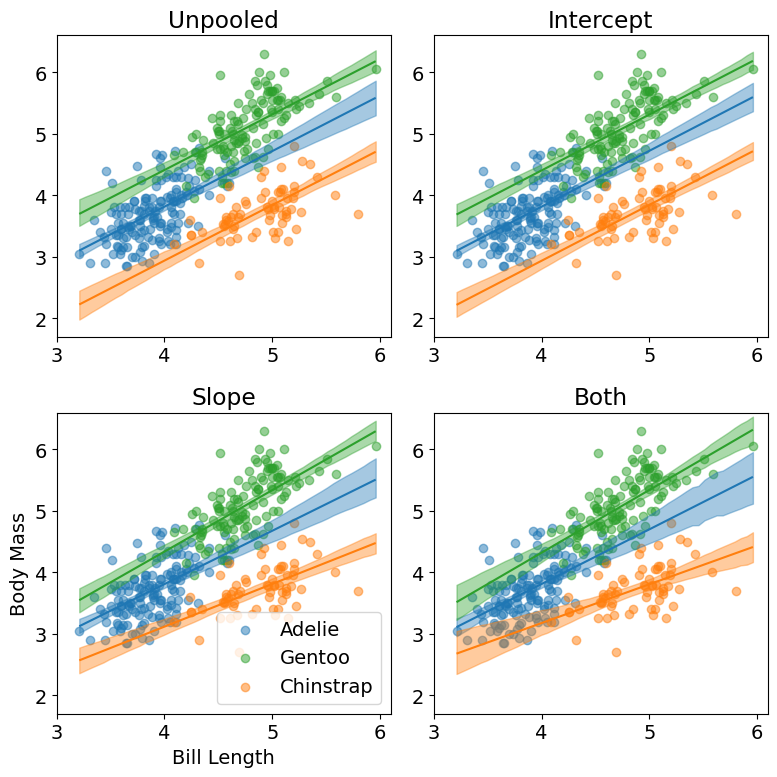

In [52]:
models = [model_unpooled_bmb, model_hierarchy_bmb, model_hierarchy_slope, model_hierarchy_both]
idatas = [idata_unpooled_bmb, idata_hierarchy_bmb, idata_hierarchy_slope, idata_hierarchy_both]
names = ["Unpooled", "Intercept", "Slope", "Both"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for model, idata, name, ax in zip(models, idatas, names, axes.flatten()):
    for cat in species_categories:
        # Scatter data points for the species
        category_data = penguins[penguins.species == cat]
        ax.scatter(
            category_data.bill_length, 
            category_data.body_mass, 
            color=category_color_map[cat], 
            alpha=0.5, 
            label=cat
        )

    bmb.interpret.plot_predictions(model, idata, ["bill_length",  "species"], ax=ax)

    ax.set_ylim([1.7, 6.6])
    ax.set_xlim([3.0, 6.1])
    ax.set_title(name)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend().remove()

axes[1,0].set_xlabel("Bill Length")
axes[1,0].set_ylabel("Body Mass")
axes[1,0].legend() 
plt.tight_layout()
plt.show()

## Model comparison

In [53]:
az.compare(dict(zip(names, idatas)))


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Slope,0,-145.787796,4.710177,0.000000,1.000000e+00,12.778745,0.000000,False,log
Both,1,-146.424194,5.662143,0.636397,0.000000e+00,12.810754,0.487898,False,log
Intercept,2,-148.735439,4.497374,2.947642,2.473226e-16,12.720168,1.817885,False,log
Unpooled,3,-148.948370,4.694366,3.160574,0.000000e+00,12.725699,1.777338,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

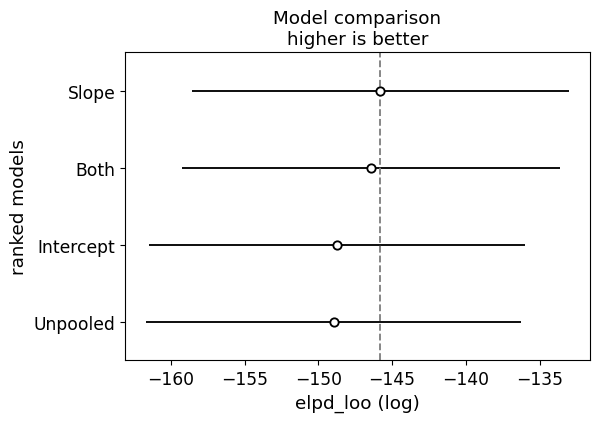

In [55]:
az.plot_compare(az.compare(dict(zip(names, idatas))))